In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from optbinning import BinningProcess
import ppscore as pps
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
data = pd.read_csv('../01_data/transaction_dataset.csv', index_col='Unnamed: 0')

# Remove duplicates
data = data.drop(columns=['Index'])
data = data.drop_duplicates()

# Rename features
rename_feat = pd.read_csv('../01_data/data_dictionary.csv')
rename_feat = {k: v for k, v in zip(rename_feat['Column'], rename_feat['Renamed'])}
data.columns = [col.strip() for col in data.columns]
data = data.rename(columns=rename_feat)

# Remove features with constant values
data = data.drop(
    columns=[
        'erc20_transaction_time__erc20 avg time between sent tnx',
        'erc20_transaction_time__erc20 avg time between rec tnx',
        'erc20_transaction_time__erc20 avg time between rec 2 tnx',
        'erc20_transaction_time__erc20 avg time between contract tnx',
        'erc20_value__erc20 min val sent contract',
        'erc20_value__erc20 max val sent contract',
        'erc20_value__erc20 avg val sent contract',
    ]
)

print(data.shape)
data.head()

(9823, 42)


,address,flag,transaction_time__avg min between sent tnx,transaction_time__avg min between received tnx,transaction_time__time diff between first and last (mins),number_of_transactions__sent tnx,number_of_transactions__received tnx,number_of_transactions__number of created contracts,number_of_transactions__unique received from addresses,number_of_transactions__unique sent to addresses,...,erc20_value__erc20 min val rec,erc20_value__erc20 max val rec,erc20_value__erc20 avg val rec,erc20_value__erc20 min val sent,erc20_value__erc20 max val sent,erc20_value__erc20 avg val sent,erc20__erc20 uniq sent token name,erc20__erc20 uniq rec token name,token__erc20 most sent token type,token__erc20_most_rec_token_type
0,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,118,...,0.0,1.500000e+07,265586.147600,0.000000,1.683100e+07,271779.920000,39.0,57.0,Cofoundit,Numeraire
1,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,14,...,0.0,3.650000e+02,57.632615,2.260809,2.260809e+00,2.260809,1.0,7.0,Livepeer Token,Livepeer Token
2,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,2,...,0.0,4.428198e+02,65.189009,0.000000,0.000000e+00,0.000000,0.0,8.0,None,XENON
3,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,13,...,0.0,1.141223e+04,1555.550174,100.000000,9.029231e+03,3804.076893,1.0,11.0,Raiden,XENON
4,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,19,...,0.0,9.000000e+04,4934.232147,0.000000,4.500000e+04,13726.659220,6.0,27.0,StatusNetwork,EOS


In [3]:
# One-hot encoding for the categorical values
data['token__erc20 most sent token type'] = np.where(data['token__erc20 most sent token type']==' ', 1, 0)
data['token__erc20_most_rec_token_type_Blockwell'] = np.where(data['token__erc20_most_rec_token_type']=='Blockwell say NOTSAFU', 1, 0)
data = data.drop(columns=['token__erc20_most_rec_token_type'])

# Fill na with 0 for numerical values
data = data.fillna(0)

# Train-test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['flag', 'address'], axis=0),
    data['flag'],
    test_size=0.2, random_state=123,
    stratify=data['flag']
)
print(X_train.shape)
print(X_test.shape)

(7858, 40)
(1965, 40)


In [5]:
X_train.head()

,transaction_time__avg min between sent tnx,transaction_time__avg min between received tnx,transaction_time__time diff between first and last (mins),number_of_transactions__sent tnx,number_of_transactions__received tnx,number_of_transactions__number of created contracts,number_of_transactions__unique received from addresses,number_of_transactions__unique sent to addresses,ether_value__min value received,ether_value__max value received,...,erc20_value__erc20 min val rec,erc20_value__erc20 max val rec,erc20_value__erc20 avg val rec,erc20_value__erc20 min val sent,erc20_value__erc20 max val sent,erc20_value__erc20 avg val sent,erc20__erc20 uniq sent token name,erc20__erc20 uniq rec token name,token__erc20 most sent token type,token__erc20_most_rec_token_type_Blockwell
1598,6.73,0.27,20.72,3,2,0,2,3,458.500397,1542.499603,...,0.000000,0.00000,0.000000,0.0,0.0,0.0000,0.0,0.0,0,0
5559,0.00,0.00,23.72,1,1,0,1,1,0.100000,0.100000,...,0.000000,0.00000,0.000000,0.0,0.0,0.0000,0.0,0.0,0,0
4175,10726.92,5300.98,706977.08,58,16,0,6,25,0.100000,12.500000,...,0.000000,125000.00000,7814.612546,0.0,124900.0,17823.6695,12.0,34.0,0,0
8500,0.00,49440.55,197762.18,0,4,1,3,0,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.0,0.0,0.0000,0.0,0.0,0,0
3685,0.00,2099.66,226763.67,0,108,1,10,0,0.000000,10.750000,...,0.759846,2.86657,1.813208,0.0,0.0,0.0000,0.0,2.0,0,0


In [51]:
# Save train test split id
pd.DataFrame(y_train).to_csv('../03_outputs/02/train_id.csv')
pd.DataFrame(y_test).to_csv('../03_outputs/02/test_id.csv')

# Feature Engineering
## Optimal Binning

In [53]:
# Optimal binning
var_num = list(X_train.columns[:-2])
var_cate = ['token__erc20 most sent token type', 'token__erc20_most_rec_token_type_Blockwell']

# Numerical
binning_fit_params = {v:{'monotonic_trend':'auto_asc_desc'} for v in var_num}

# Binning process
bin_proc_num = BinningProcess(
    var_num,
    max_n_bins=8,
    binning_fit_params=binning_fit_params
)

# Categorical
bin_proc_cate = BinningProcess(
    var_cate,
    max_n_bins=8,
)

# Apply opt binning to train dataset
train_bin = X_train.copy()
train_bin[var_num] = bin_proc_num.fit_transform(train_bin[var_num].values, y_train)
train_bin[var_cate] = bin_proc_cate.fit_transform(train_bin[var_cate].values, y_train)

print(train_bin.shape)
train_bin.head(3)

(7858, 40)


,transaction_time__avg min between sent tnx,transaction_time__avg min between received tnx,transaction_time__time diff between first and last (mins),number_of_transactions__sent tnx,number_of_transactions__received tnx,number_of_transactions__number of created contracts,number_of_transactions__unique received from addresses,number_of_transactions__unique sent to addresses,ether_value__min value received,ether_value__max value received,...,erc20_value__erc20 min val rec,erc20_value__erc20 max val rec,erc20_value__erc20 avg val rec,erc20_value__erc20 min val sent,erc20_value__erc20 max val sent,erc20_value__erc20 avg val sent,erc20__erc20 uniq sent token name,erc20__erc20 uniq rec token name,token__erc20 most sent token type,token__erc20_most_rec_token_type_Blockwell
1598,0.780624,-1.110223e-16,-0.165655,0.619978,0.063357,-0.083904,0.276073,0.715314,4.117050,2.669309,...,0.482962,0.502339,-0.109946,-0.051105,-0.117826,-0.116838,-0.124015,-0.170604,-1.110223e-16,-1.110223e-16
5559,-0.898807,-1.110223e-16,-0.165655,-0.898807,0.063357,-0.083904,0.276073,-0.297257,-0.171873,-0.315506,...,0.482962,0.502339,-0.109946,-0.051105,-0.117826,-0.116838,-0.124015,-0.170604,-1.110223e-16,-1.110223e-16
4175,0.780624,-1.110223e-16,2.654884,1.099895,0.063357,-0.083904,0.276073,1.082539,-0.171873,0.304081,...,0.482962,-0.618918,0.523898,-0.051105,0.912262,0.907521,1.136051,1.195868,-1.110223e-16,-1.110223e-16


In [54]:
# Summary
bin_proc_num.summary().sort_values('iv', ascending=False)

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
10,ether_value__avg val received,numerical,OPTIMAL,True,6,2.497286,0.211171,0.617299,0.0
19,ether__total ether received,numerical,OPTIMAL,True,8,2.254575,0.209285,0.653664,0.0
9,ether_value__max value received,numerical,OPTIMAL,True,8,2.063313,0.187132,0.588904,0.000002
2,transaction_time__time diff between first and ...,numerical,OPTIMAL,True,6,1.961629,0.159395,0.509419,0.000016
4,number_of_transactions__received tnx,numerical,OPTIMAL,True,6,1.66476,0.120359,0.380468,0.000226
6,number_of_transactions__unique received from a...,numerical,OPTIMAL,True,2,1.356715,0.088957,0.240967,0.002182
18,ether__total ether sent,numerical,OPTIMAL,True,6,1.259772,0.131392,0.483427,0.029976
8,ether_value__min value received,numerical,OPTIMAL,True,6,1.257253,0.11235,0.434365,0.028767
30,erc20_value__erc20 min val rec,numerical,OPTIMAL,True,2,0.962666,0.104633,0.364756,0.062209
3,number_of_transactions__sent tnx,numerical,OPTIMAL,True,7,0.878876,0.098171,0.457248,0.176398


In [55]:
bin_proc_cate.summary().sort_values('iv', ascending=False)

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
0,token__erc20 most sent token type,numerical,OPTIMAL,True,1,0.0,0.0,0,0.0
1,token__erc20_most_rec_token_type_Blockwell,numerical,OPTIMAL,True,1,0.0,0.0,0,0.0


In [21]:
bin_proc_num.get_binned_variable('ether_value__avg val received').binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.00)",553,0.070374,41,512,0.925859,-3.77989,1.084986,0.088066
1,"[0.00, 1.57)",3273,0.416518,2334,939,0.286893,-0.344614,0.054119,0.006732
2,"[1.57, 3.45)",775,0.098626,593,182,0.234839,-0.073949,0.000550,0.000069
3,"[3.45, 5.47)",393,0.050013,357,36,0.091603,1.03908,0.039201,0.004691
4,"[5.47, 24.93)",938,0.119369,876,62,0.066098,1.393095,0.150013,0.017369
5,"[24.93, inf)",1926,0.245101,1914,12,0.006231,3.816907,1.168417,0.094245
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,7858,1.000000,6115,1743,0.221812,,2.497286,0.211171


In [56]:
bin_proc_cate.get_binned_variable('token__erc20 most sent token type').binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",7858,1.0,6115,1743,0.221812,-0.0,0.0,0.0
1,Special,0,0.0,0,0,0.000000,0.0,0.0,0.0
2,Missing,0,0.0,0,0,0.000000,0.0,0.0,0.0
Totals,,7858,1.0,6115,1743,0.221812,,0.0,0.0


In [63]:
# Compile opt binning tables
# Sort the variables based on IV
var_num_sort = list(bin_proc_num.summary().sort_values('iv', ascending=False)['name'].values)
var_obj_sort = list(bin_proc_cate.summary().sort_values('iv', ascending=False)['name'].values)

# Numerical
bin_table_num = pd.DataFrame(
    {'Feature':[], 'Bin':[], 'Count':[], 'Count (%)':[], 'WoE':[], 'IV':[]}
)
for c in var_num_sort:
    df_bin = bin_proc_num.get_binned_variable(c).binning_table.build()
    df_bin = df_bin[df_bin['Count']!=0]
    df_bin.insert(0, 'Feature', c)
    bin_table_num = pd.concat([bin_table_num, df_bin], axis=0, ignore_index=True)

# Object
bin_table_cate = pd.DataFrame(
    {'Feature':[], 'Bin':[], 'Count':[], 'Count (%)':[], 'WoE':[], 'IV':[]}
)
for c in var_obj_sort:
    df_bin = bin_proc_cate.get_binned_variable(c).binning_table.build()
    df_bin = df_bin[df_bin['Count']!=0]
    df_bin.insert(0, 'Feature', c)
    bin_table_cate = pd.concat([bin_table_cate, df_bin], axis=0, ignore_index=True)

In [64]:
# Save opt binning
bin_table_num.to_csv('../03_outputs/02/bin_table_num.csv', index=False)

## Predictive Power Score (PPS)

In [7]:
# PPS is the substitute to the correlation test that is usually userd to find features with strong relationship
# Apply predictive power
train_pps = pps.matrix(pd.concat([X_train, y_train], axis=1))
train_pps.head()

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,transaction_time__avg min between sent tnx,transaction_time__avg min between sent tnx,1.0,predict_itself,True,None,0.000000,1.000000,None
1,transaction_time__avg min between sent tnx,transaction_time__avg min between received tnx,0.0,regression,True,mean absolute error,8417.044038,12903.229007,DecisionTreeRegressor()
2,transaction_time__avg min between sent tnx,transaction_time__time diff between first and ...,0.0,regression,True,mean absolute error,215952.370092,232816.609233,DecisionTreeRegressor()
3,transaction_time__avg min between sent tnx,number_of_transactions__sent tnx,0.0,regression,True,mean absolute error,100.986400,177.654671,DecisionTreeRegressor()
4,transaction_time__avg min between sent tnx,number_of_transactions__received tnx,0.0,regression,True,mean absolute error,146.701000,242.267734,DecisionTreeRegressor()


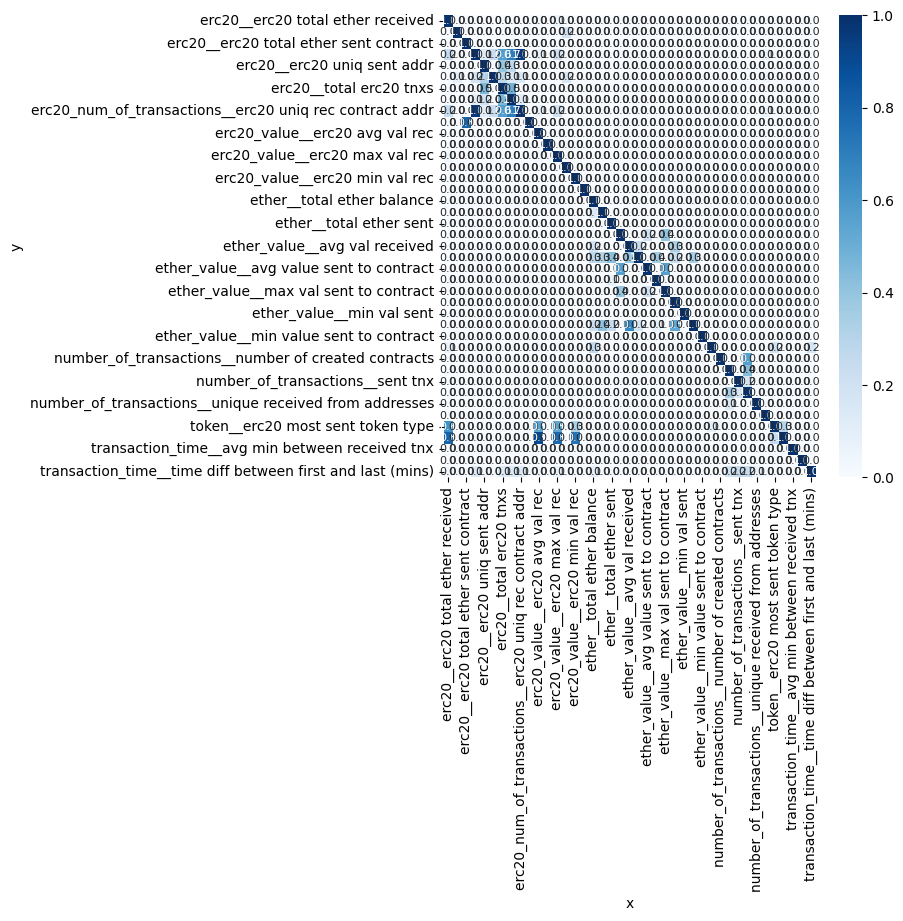

In [ ]:
# Plot pps
plt.figure(figsize=(6, 6))
pps_matrix = train_pps[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
sns.heatmap(
    pps_matrix,
    annot=True, fmt=".1f", annot_kws={'size': 8}, cmap="Blues"
)
plt.show()

In [ ]:
# Save
train_pps.to_csv("../03_outputs/02/ppscore.csv", index=False)
pps_matrix.to_csv("../03_outputs/02/pps_matrix.csv")

In [6]:
# Save
X_train.to_csv('../03_outputs/02/X_train.csv')
y_train.to_csv('../03_outputs/02/y_train.csv')
X_test.to_csv('../03_outputs/02/X_test.csv')
y_test.to_csv('../03_outputs/02/y_test.csv')